# Duolingo Option Pricing using BlackScholesModel 
Date: 09-05-2024

In [2]:
#Importing dependancies 
import yfinance as yf
import numpy as np
import pandas as pd 
import scipy.stats as si
import matplotlib.pyplot as plt
import mplfinance as mpf 
import plotly.graph_objects as go
from datetime import datetime
from datetime import date


The Ticker module, which allows you to access ticker data in a more Pythonic way.
# Some useful functions of yfinance 
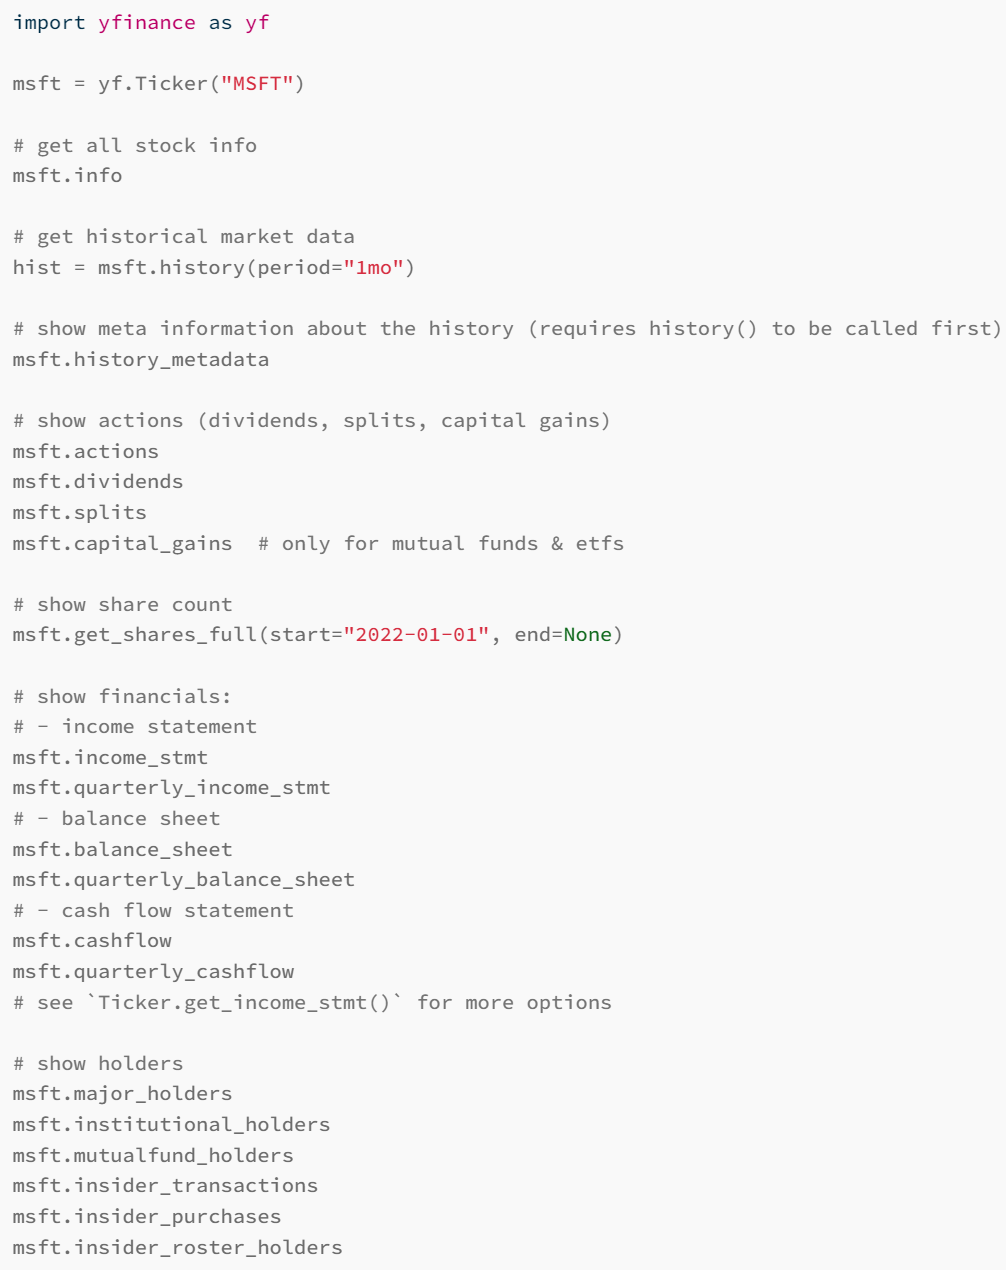
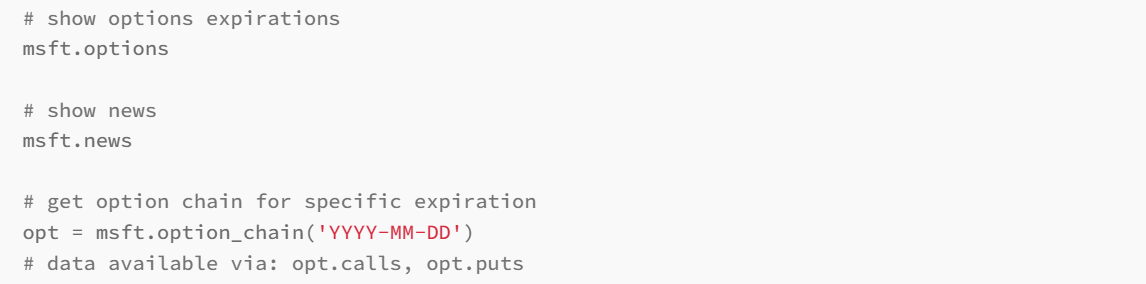

In [29]:
def  GetOptionData(symbol):   
    ticker = yf.Ticker(symbol)
    #options is a yfinance function used for options expirations
    OptionsDates = ticker.options 
    # using the closest expiry date for the analysis
    OptionsData = ticker.option_chain(OptionsDates[0])
    return OptionsData.calls , OptionsData.puts

DUOLcalls , DUOLputs = GetOptionData('DUOL')
DUOLcalls, DUOLputs

(         contractSymbol             lastTradeDate  strike  lastPrice    bid  \
 0   DUOL240517C00100000 2024-05-08 19:48:55+00:00   100.0     145.70    0.0   
 1   DUOL240517C00110000 2024-04-02 13:31:51+00:00   110.0     102.00  114.3   
 2   DUOL240517C00120000 2023-10-05 18:09:09+00:00   120.0      56.40   50.8   
 3   DUOL240517C00125000 2023-12-28 20:47:26+00:00   125.0     113.25   70.0   
 4   DUOL240517C00130000 2024-04-16 16:52:12+00:00   130.0      71.00    0.0   
 5   DUOL240517C00135000 2023-11-09 15:05:20+00:00   135.0      71.90   85.2   
 6   DUOL240517C00140000 2024-02-29 14:36:57+00:00   140.0      98.00   80.2   
 7   DUOL240517C00145000 2024-02-12 17:36:18+00:00   145.0      57.17   81.5   
 8   DUOL240517C00150000 2024-05-03 18:46:44+00:00   150.0      90.00    0.0   
 9   DUOL240517C00155000 2024-01-19 19:29:03+00:00   155.0      49.40   38.9   
 10  DUOL240517C00160000 2024-05-08 17:46:02+00:00   160.0      86.66    0.0   
 11  DUOL240517C00165000 2024-04-26 13:4

[*********************100%%**********************]  1 of 1 completed


Text(0, 0.5, 'Stock Price (USD)')

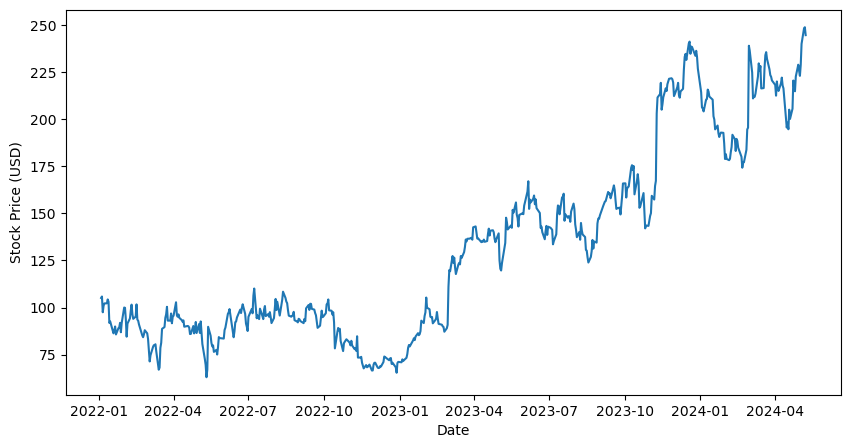

In [30]:
Today = date.today()
StartDate = '2022-01-01'
DUOLstockData =  yf.download('DUOL', StartDate, Today)

# plotting the option data
plt.figure( figsize=(10,5))
plt.plot(DUOLstockData["Close"])
plt.xlabel('Date')
plt.ylabel('Stock Price (USD)')
# plt.grid(True)

In [32]:
# Defining the Black Scholes Model

class BlackScholesModel:
    def __init__(self,S,K,t,r,sigma):
        self.K = K  # strike price
        self.S = S  # stock price
        self.t = t  # time to expiration
        self.r = r  # risk free rate
        self.sigma = sigma  # volatility 
        
    def d1(self):
        return (np.log(self.S /self.K)  + (self.r + 0.5 * self.sigma **2)* self.t)/(self.sigma * np.sqrt(self.t))
    
    def d2(self):
        return  self.d1() - self.sigma * np.sqrt(self.t)
    
    def CallOptionPrice(self):
        return  (self.S * si.norm.cdf(self.d1(), 0.0 ,1.0) - self.K * np.exp(-self.r * self.t)*si.norm.cdf(self.d2(),  0.0, 1.0))
    
    def PutOptionPrice(self):
        return (self.K * np.exp(-self.r * self.t) *si.norm.cdf(-self.d2(), 0.0,1.0) - self.S * si.norm.cdf(self.d1()  ,0.0, 1.0))
    

bsm = BlackScholesModel(S = 100, K = 100, t = 1,r = 0.05, sigma =  0.2)
print(bsm.CallOptionPrice())
print(bsm.PutOptionPrice())

10.450583572185565
-21.79260421286685


In [33]:
# function to calculate the volatility 
def VolatalityCalculation(StockData ,window = 252  ):
    log_returns =  np.log(StockData["Close"].pct_change())
    volatility  = np.sqrt(window) *log_returns.std()
    return volatility

DUOLvolatility = VolatalityCalculation(DUOLstockData)
print(DUOLvolatility)

19.336881454766804


C:\Users\paras\anaconda3\Lib\site-packages\pandas\core\arraylike.py:396: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [37]:
class BlackScholesGreeks(BlackScholesModel):
    def DeltaCall(self):
        return si.norm.cdf(self.d1() , 0.0, 1.0)
    
    def DeltaPut(self):
        return -si.norm.cdf(-self.d1() , 0.0, 1.0)
    
    def Gamma(self):
        return (si.norm.pdf(self.d1(),0.0,1.0)/(self.sigma*self.S*np.sqrt(self.t)))
    
    def ThetaCall(self):
        return (-(self.S*self.sigma*si.norm.pdf(self.d1(),0.0,1.0)/ (2*np.sqrt(self.t))) - self.r*self.K.np.exp(-self.r*self.t)*si.norm.cdf(self.d2(),0.0,1.0))/self.t
    
    def ThetaPut(self):
        return (-(self.S*self.sigma*si.norm.pdf(self.d1(),0.0,1.0)/ (2*np.sqrt(self.t))) + self.r*self.K.np.exp(-self.r*self.t)*si.norm.cdf(-self.d2(),0.0,1.0))/self.t
    
    def Vega(self):
        return (self.S*np.sqrt(self.t)*si.norm.pdf(self.d1(),0.0,1.0))/100
    
    def RhoCall(self):
        return (self.K*self.t*np.exp(-self.r*self.t*si.norm.cdf(self.d2(),0.0,1.0)))/100
    
    def RhoPut(self):
        return -(self.K*self.t*np.exp(-self.r*self.t*si.norm.cdf(-self.d2(),0.0,1.0)))/100
    
bsg =BlackScholesGreeks( S= 100 ,  K =100,  t =1 ,r = 0.05,sigma =0.2)
print(bsg.DeltaCall())
print(bsg.DeltaPut())

0.6368306511756191
-0.3631693488243809


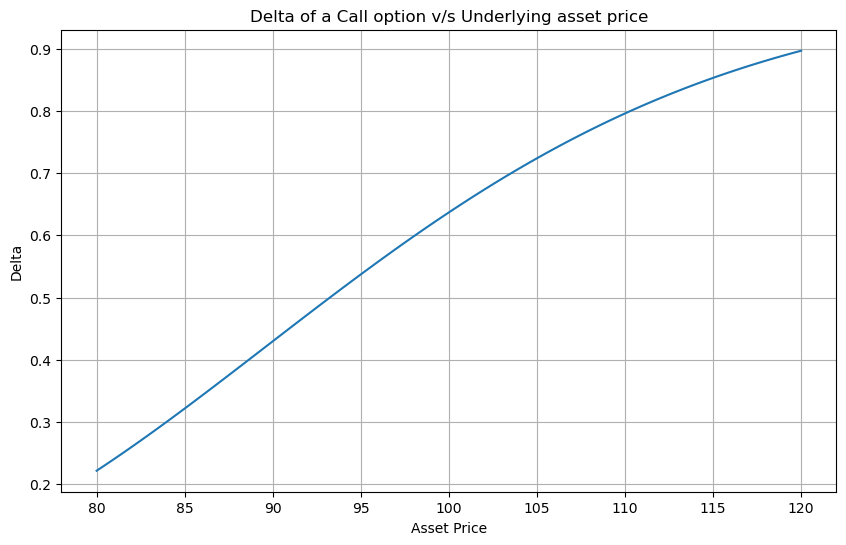

In [38]:
StockPrices =  np.linspace(80,120,100)
deltas = [BlackScholesGreeks(S =price,  K =100, t =1,r = 0.05,sigma = 0.2 ).DeltaCall() for price in  StockPrices]

plt.figure(figsize=(10,6))
plt.plot(StockPrices, deltas)
plt.title("Delta of a Call option v/s Underlying asset price")
plt.xlabel("Asset Price")
plt.ylabel("Delta")
plt.grid(True)

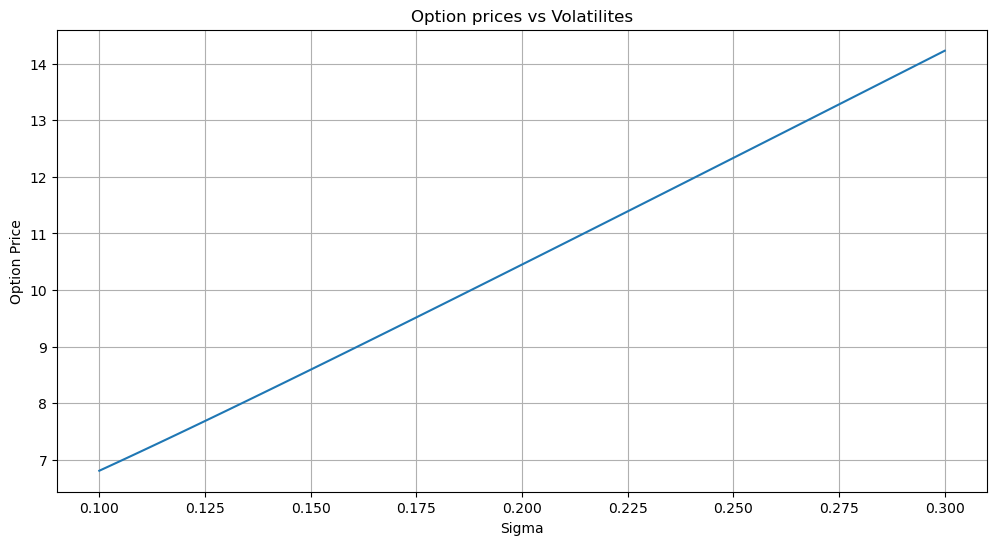

In [41]:
def PlotOptionSensitivity(BSmodel,  parameter, values, option_type = "call"):
    prices =  []
    for value in values:
        setattr(BSmodel,  parameter, value)
        if option_type == "call":
            prices.append(BSmodel.CallOptionPrice())
        else:
            prices.append(BSmodel.PutOptionPrice())
    
    plt.figure(figsize =(12,6))
    plt.plot(values , prices)
    plt.title("Option prices vs Volatilites")
    plt.xlabel("Sigma")
    plt.ylabel("Option Price")
    plt.grid(True)
    
volatilities = np.linspace(0.1,0.3,100)
PlotOptionSensitivity(bsm,"sigma" ,volatilities, "call")

Text(0, 0.5, 'Option Price')

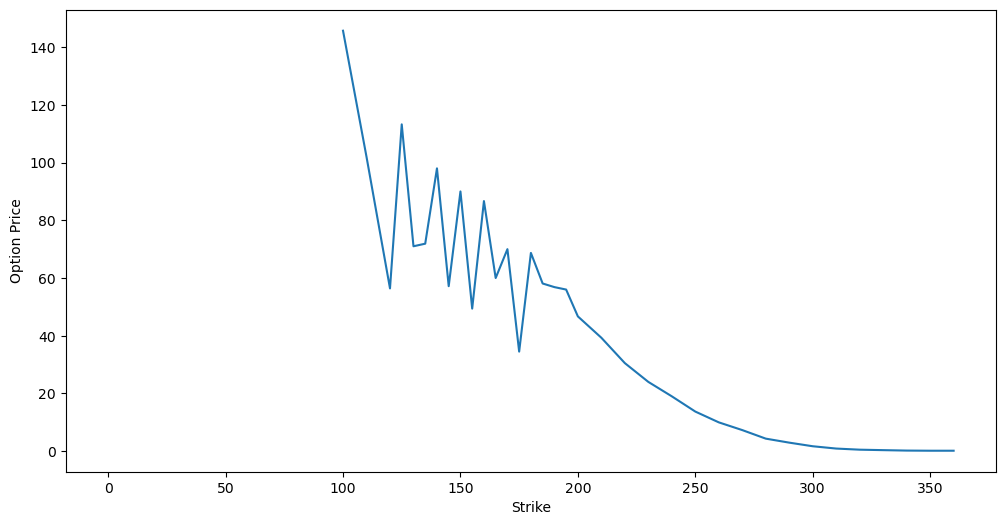

In [42]:
plt.figure(figsize= (12,6))
plt.plot(DUOLcalls["strike"]  ,DUOLcalls['lastPrice'])
plt.plot(bsm.CallOptionPrice())
plt.xlabel("Strike")
plt.ylabel("Option Price")

In [43]:
DUOLcalls['lastTradeDate'][1]

Timestamp('2024-04-02 13:31:51+0000', tz='UTC')

In [44]:
DUOLcalls.head()

,contractSymbol,lastTradeDate,strike,lastPrice,bid,ask,change,percentChange,volume,openInterest,impliedVolatility,inTheMoney,contractSize,currency
0,DUOL240517C00100000,2024-05-08 19:48:55+00:00,100.0,145.70,0.0,0.0,0.0,0.0,1.0,0,0.00001,True,REGULAR,USD
1,DUOL240517C00110000,2024-04-02 13:31:51+00:00,110.0,102.00,114.3,118.8,0.0,0.0,NaN,1,0.00001,True,REGULAR,USD
2,DUOL240517C00120000,2023-10-05 18:09:09+00:00,120.0,56.40,50.8,54.4,0.0,0.0,NaN,0,0.00001,True,REGULAR,USD
3,DUOL240517C00125000,2023-12-28 20:47:26+00:00,125.0,113.25,70.0,74.4,0.0,0.0,1.0,1,0.00001,True,REGULAR,USD
4,DUOL240517C00130000,2024-04-16 16:52:12+00:00,130.0,71.00,0.0,0.0,0.0,0.0,1.0,0,0.00001,True,REGULAR,USD


In [46]:

from datetime import datetime
import pandas as pd

# Example Series containing datetime strings
datetime_series = pd.Series(["2024-05-08 19:48:55+00:00", "2023-12-28 20:47:26+00:00"])

# Function to convert each datetime string to date
def convert_to_date(datetime_string):
    datetime_object = datetime.strptime(datetime_string, "%Y-%m-%d %H:%M:%S%z")
    return datetime_object.date()

# Apply the function to each element of the Series
date_series = datetime_series.apply(convert_to_date)

print(date_series)
print(datetime_series)


0    2024-05-08
1    2023-12-28
dtype: object
0    2024-05-08 19:48:55+00:00
1    2023-12-28 20:47:26+00:00
dtype: object
